In [1]:
from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import EnergyDistanceLoss
from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN 

import networkx as nx
from matplotlib import pyplot as plt
import torch
import copy
import numpy as np

from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out
from gsnn.models.utils import corr_score

torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

# Bug: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"torch_geometric\.utils\._scatter"
)


/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Uncertainty quantification with hypernetworks

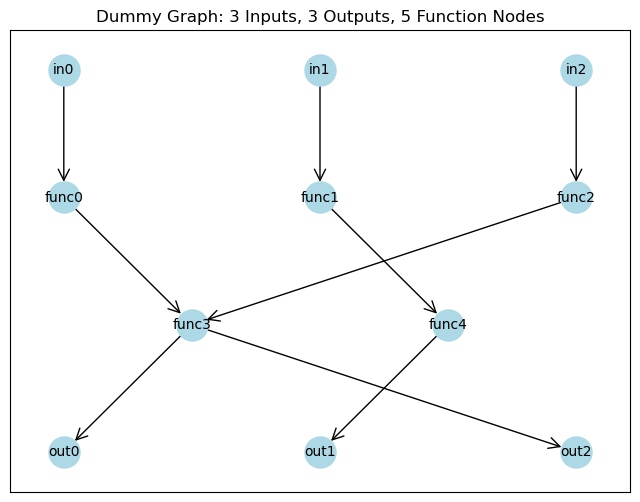

In [2]:

G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=25, 
                                                                    n_test=250, 
                                                                    noise_scale=1.)

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

## First, we'll use GSNN wrapped in a hypernet 

In [4]:
gsnn = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=10, 
             layers=3,
             share_layers=False, 
             bias=True,
             residual=True,
             add_function_self_edges=True,
             norm='none', # NOTE: our hypernet implementation is not compatible with batch norm 
             dropout=0).to(device)

model = HyperNet(gsnn, stochastic_channels=5, width=100).to(device)

print('n params (gsnn)', sum([p.numel() for p in gsnn.parameters()]))
print('n params (hypernet)', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
crit = EnergyDistanceLoss()

samples = 100

n params (gsnn) 852
n params (hypernet) 86576


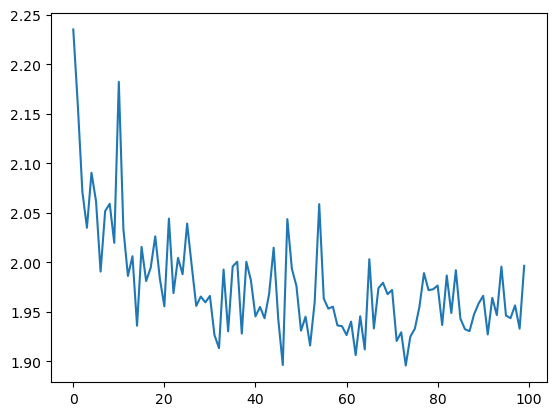

In [5]:

losses_gsnn = []
for i in range(100): 
    model.train() 
    optim.zero_grad() 

    yhat = model(x_train.to(device), samples=samples) 

    loss = crit(yhat, y_train.to(device))
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat_test = model(x_test.to(device), samples=samples)
        test_loss = crit(yhat_test, y_test.to(device))
        losses_gsnn.append(test_loss.item())
        r2 = corr_score(y_test.detach().cpu().numpy(), yhat_test.mean(dim=0).detach().cpu().numpy(), method='r2', multioutput='uniform_weighted')

    print(f'iter: {i} | loss: {loss.item():.3f} | test loss: {test_loss.item():.3f} | test r2: {r2:.3f}',end='\r')

plt.plot(losses_gsnn)
plt.show()

In [6]:
model.eval() 
with torch.no_grad(): 
    yhat_test = model(x_test.to(device), samples=250).detach().cpu().numpy() 

mse = np.mean((yhat_test.mean(0) - y_test.detach().cpu().numpy())**2)
r2 = corr_score(y_test.detach().cpu().numpy(), yhat_test.mean(0), method='r2', multioutput='uniform_weighted')

print('GSNN + HyperNet:')
print(f'\t mse: {mse:.3f}')
print(f'\t r2: {r2:.3f}')

GSNN + HyperNet:
	 mse: 0.745
	 r2: 0.216


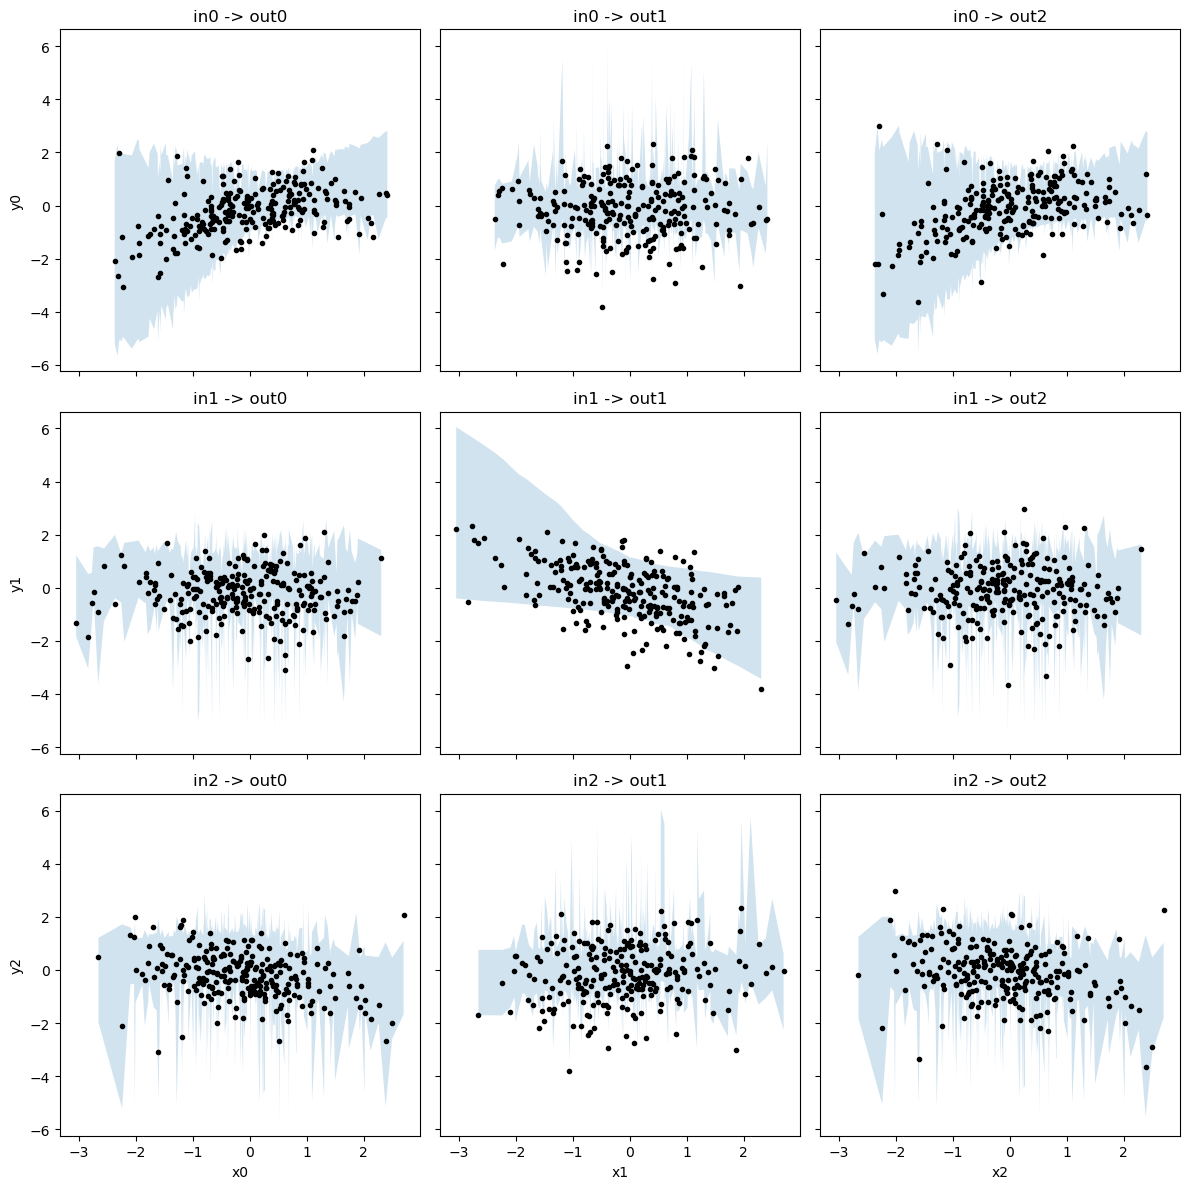

In [7]:
yhat_lcb = np.quantile(yhat_test, 0.05, axis=0)
yhat_ucb = np.quantile(yhat_test, 0.95, axis=0)
yhat_mean = yhat_test.mean(axis=0)

f,axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)

for xi in range(3):
    for yi in range(3): 

        axes[xi,yi].plot(x_test[:,xi], y_test[:,yi], 'k.') 

        x_argsort = np.argsort(x_test[:,xi]) 
        axes[xi,yi].fill_between(x_test[x_argsort,xi], yhat_lcb[x_argsort,yi], yhat_ucb[x_argsort,yi], alpha=0.2)
        axes[xi,yi].set_title(f'{input_nodes[xi]} -> {output_nodes[yi]}')

axes[0,0].set_ylabel('y0')
axes[1,0].set_ylabel('y1')
axes[2,0].set_ylabel('y2')

axes[2,0].set_xlabel('x0')
axes[2,1].set_xlabel('x1')
axes[2,2].set_xlabel('x2')
plt.tight_layout()
plt.show()


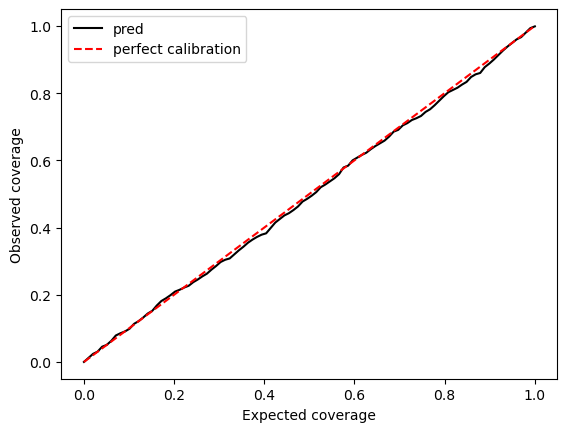

In [8]:
# calibration plot 

q_true = np.linspace(0,1,100)
q_pred = [] 

for q in q_true: 
    q_lcb, q_ucb = np.quantile(yhat_test, [0.5 - q/2, 0.5 + q/2], axis=0)
    p_inside = np.mean((y_test.detach().cpu().numpy() >= q_lcb) & (y_test.detach().cpu().numpy() <= q_ucb)) 
    q_pred.append(p_inside) 

plt.figure() 
plt.plot(q_true, q_pred, 'k-', label='pred') 
plt.plot(q_true, q_true, 'r--', label='perfect calibration') 
plt.xlabel('Expected coverage') 
plt.ylabel('Observed coverage') 
plt.legend() 
plt.show() 

## Next, we'll compare to NN wrapped in Hypernet

In [24]:
nn = NN(in_channels=3, hidden_channels=25, out_channels=3, layers=2, norm=torch.nn.Identity)
model = HyperNet(nn, stochastic_channels=5, width=100).to(device)

print('n params (nn)', sum([p.numel() for p in nn.parameters()]))
print('n params (hypernet)', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
crit = EnergyDistanceLoss()

samples = 100

n params (nn) 828
n params (hypernet) 84140


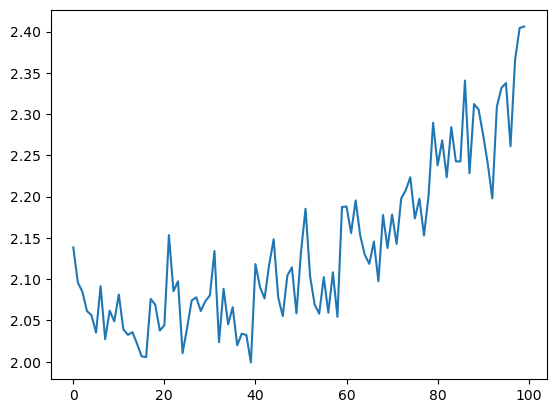

In [25]:

losses_gsnn = []
for i in range(100): 
    model.train() 
    optim.zero_grad() 

    yhat = model(x_train.to(device), samples=samples) 

    loss = crit(yhat, y_train.to(device))
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat_test = model(x_test.to(device), samples=samples)
        test_loss = crit(yhat_test, y_test.to(device))
        losses_gsnn.append(test_loss.item())
        r2 = corr_score(y_test.detach().cpu().numpy(), yhat_test.mean(dim=0).detach().cpu().numpy(), method='r2', multioutput='uniform_weighted')

    print(f'iter: {i} | loss: {loss.item():.3f} | test loss: {test_loss.item():.3f} | test r2: {r2:.3f}',end='\r')

plt.plot(losses_gsnn)
plt.show()

In [26]:
model.eval() 
with torch.no_grad(): 
    yhat_test = model(x_test.to(device), samples=250).detach().cpu().numpy() 

mse = np.mean((yhat_test.mean(0) - y_test.detach().cpu().numpy())**2)
r2 = corr_score(y_test.detach().cpu().numpy(), yhat_test.mean(0), method='r2', multioutput='uniform_weighted')

print('NN + HyperNet:')
print(f'\t mse: {mse:.3f}')
print(f'\t r2: {r2:.3f}')


NN + HyperNet:
	 mse: 1.713
	 r2: -0.806


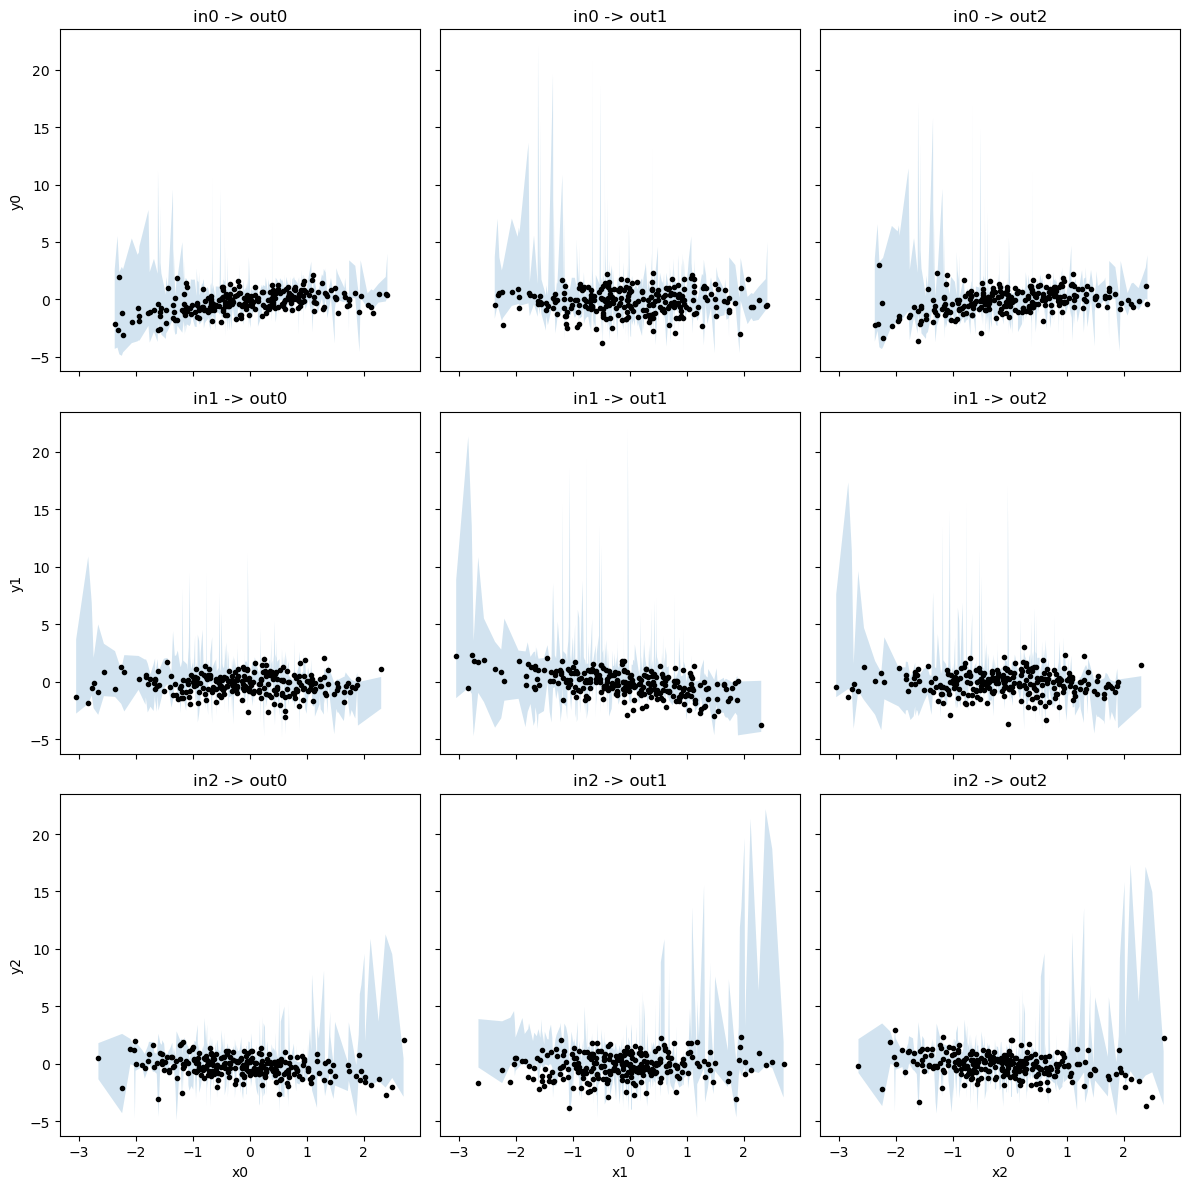

In [27]:
yhat_lcb = np.quantile(yhat_test, 0.05, axis=0)
yhat_ucb = np.quantile(yhat_test, 0.95, axis=0)
yhat_mean = yhat_test.mean(axis=0)

f,axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)

for xi in range(3):
    for yi in range(3): 

        axes[xi,yi].plot(x_test[:,xi], y_test[:,yi], 'k.') 

        x_argsort = np.argsort(x_test[:,xi]) 
        axes[xi,yi].fill_between(x_test[x_argsort,xi], yhat_lcb[x_argsort,yi], yhat_ucb[x_argsort,yi], alpha=0.2)
        axes[xi,yi].set_title(f'{input_nodes[xi]} -> {output_nodes[yi]}')

axes[0,0].set_ylabel('y0')
axes[1,0].set_ylabel('y1')
axes[2,0].set_ylabel('y2')

axes[2,0].set_xlabel('x0')
axes[2,1].set_xlabel('x1')
axes[2,2].set_xlabel('x2')
plt.tight_layout()
plt.show()


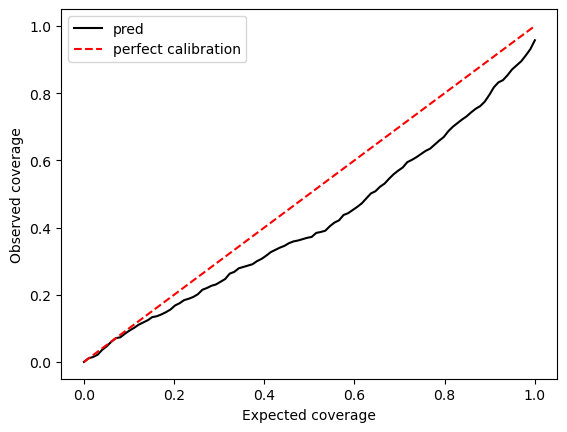

In [28]:
# calibration plot 

q_true = np.linspace(0,1,100)
q_pred = [] 

for q in q_true: 
    q_lcb, q_ucb = np.quantile(yhat_test, [0.5 - q/2, 0.5 + q/2], axis=0)
    p_inside = np.mean((y_test.detach().cpu().numpy() >= q_lcb) & (y_test.detach().cpu().numpy() <= q_ucb)) 
    q_pred.append(p_inside) 

plt.figure() 
plt.plot(q_true, q_pred, 'k-', label='pred') 
plt.plot(q_true, q_true, 'r--', label='perfect calibration') 
plt.xlabel('Expected coverage') 
plt.ylabel('Observed coverage') 
plt.legend() 
plt.show() 